In [1]:
#!pip install git+https://github.com/JoaquinAmatRodrigo/skforecast#master --upgrade

In [2]:
# Libraries
# ==============================================================================
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(1, '/home/ximo/Documents/GitHub/skforecast')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import cv_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import backtesting_forecaster_intervals
from skforecast.model_selection import grid_search_forecaster 


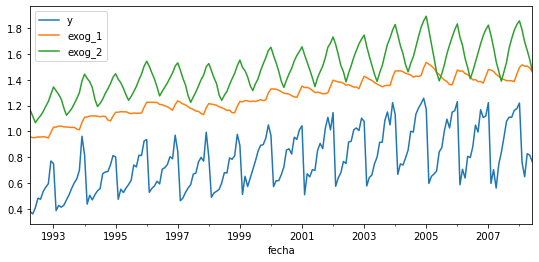

In [3]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o_exog.csv')
data = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
data['fecha'] = pd.to_datetime(data['fecha'], format='%Y/%m/%d')
data = data.set_index('fecha')
data = data.rename(columns={'x': 'y'})
data = data.asfreq('MS')
data = data.sort_index()

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data.plot(ax=ax);

## ForecasterAutoreg

In [4]:
# Cross-validation forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = Ridge(),
                lags      = 5
             )

cv_forecaster(
        forecaster  = forecaster,
        y           = data.y,
        steps       = 10,
        metric      = 'mean_squared_error',
        initial_train_size    = int(len(data)*0.5),
        allow_incomplete_fold = True,
        verbose     = True
    )

Number of folds: 10
Since `allow_incomplete_fold=True`, last fold only includes 8 observations instead of 10.
Incomplete folds with few observations could overestimate or  underestimate validation metrics.


(array([0.05315735, 0.05103496, 0.04601912, 0.0322163 , 0.0699501 ,
        0.10891208, 0.08879838, 0.06135912, 0.06047377, 0.03086596]),
 array([0.5899441 , 0.61177476, 0.65413872, 0.66782615, 0.67743059,
        0.68480755, 0.68405137, 0.67949234, 0.67589542, 0.67283807,
        0.5922186 , 0.61203978, 0.59275823, 0.62706082, 0.67214411,
        0.68629535, 0.69581611, 0.70124052, 0.6989109 , 0.69433802,
        0.87043166, 0.79187472, 0.72618362, 0.68363339, 0.67042546,
        0.6725007 , 0.67990615, 0.68984016, 0.69874257, 0.70471224,
        0.88506228, 0.809437  , 0.75537482, 0.71370429, 0.69555163,
        0.69364391, 0.6973576 , 0.70389155, 0.71055504, 0.71545593,
        0.84136232, 0.79882565, 0.76255824, 0.73409484, 0.72049055,
        0.71635046, 0.71654528, 0.71927183, 0.72260602, 0.72533665,
        0.81053506, 0.79035071, 0.7754017 , 0.75751755, 0.7474006 ,
        0.74278677, 0.74041557, 0.74007572, 0.74077298, 0.74164999,
        0.63996106, 0.67305584, 0.70994172, 0.

In [15]:
# Backtest forecaster with initial train
# ==============================================================================
n_backtest = 36*3 + 1 # Last 3 months are used for backtest
data_train = data[:-n_backtest]
data_test  = data[-n_backtest:]

forecaster = ForecasterAutoreg(
                regressor = Ridge(),
                lags      = 5 
             )

metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data.y,
                                    initial_train_size = len(data_train),
                                    steps      = 36,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                               )

print(f"Error de backtest: {metric}")
predictions_backtest

Number of observations used for training or as initial window: 86
Number of observations used for backtesting: 109
    Number of folds: 4
    Number of steps per fold: 36
    Last fold only includes 1 observations
Error de backtest: [0.09599272]


array([0.63315801, 0.65865648, 0.66087234, 0.66549297, 0.66174883,
       0.65936912, 0.65583442, 0.65385948, 0.65279822, 0.65282024,
       0.65324006, 0.65385758, 0.65436361, 0.65467689, 0.65478618,
       0.65476055, 0.6546645 , 0.65455928, 0.65447923, 0.6544362 ,
       0.65442538, 0.65443541, 0.65445384, 0.65447151, 0.65448366,
       0.65448932, 0.65448981, 0.65448734, 0.65448398, 0.65448111,
       0.65447933, 0.65447865, 0.65447877, 0.6544793 , 0.65447988,
       0.65448034, 0.65406535, 0.66559727, 0.66056579, 0.64688044,
       0.6407876 , 0.6486175 , 0.65036848, 0.65245733, 0.65519077,
       0.65637031, 0.65601601, 0.65564747, 0.65513761, 0.65458347,
       0.65426564, 0.65418531, 0.65420852, 0.65429668, 0.65440453,
       0.65448389, 0.65452385, 0.65453433, 0.6545247 , 0.65450613,
       0.65448869, 0.65447695, 0.65447146, 0.65447101, 0.65447351,
       0.65447683, 0.65447964, 0.65448138, 0.65448203, 0.6544819 ,
       0.65448138, 0.6544808 , 0.62288722, 0.64941878, 0.65194

In [6]:
forecaster.fit(y=data_train.y)
steps = 36
predictions_1 = forecaster.predict(steps=steps)
predictions_2 = forecaster.predict(steps=steps, last_window=data_test.y[:steps])
predictions_3 = forecaster.predict(steps=steps, last_window=data_test.y[steps:steps*2])
predictions_4 = forecaster.predict(steps=1, last_window=data_test.y[steps*2:steps*3])
(predictions_backtest == np.concatenate([predictions_1, predictions_2, predictions_3, predictions_4])).all()

True

In [7]:
# Backtest forecaster without initial train (forecaster already trained)
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = Ridge(),
                lags      = 15 
             )

forecaster.fit(y=data.y)

metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data.y,
                                    initial_train_size = None,
                                    steps      = 10,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                               )

print(f"Error de backtest: {metric}")

root       WARNING Altough no initial train is done, the first 15 observations are needed to create the initial predictors. Therefore, no predictions are calculated for them.


Number of observations used for training or as initial window: 15
Number of observations used for backtesting: 180
    Number of folds: 18
    Number of steps per fold: 10
Error de backtest: [0.0046328]


In [8]:
# Grid search hiperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor=Ridge(),
                lags=12
             )

# Regressor hiperparameters
param_grid ={'alpha': [0.01, 0.1, 1]}

# lags used as predictors
lags_grid = [3, 10, [1,2,3,20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data.y,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 10,
                        metric      = 'mean_squared_error',
                        method      = 'cv',
                        initial_train_size    = int(len(data)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                    )

# Results grid search
# ==============================================================================
results_grid

root       INFO  Number of models compared: 9
loop param_grid:   0%|                                    | 0/3 [00:00<?, ?it/s]
                                                                                
loop lags_grid: 100%|█████████████████████████████| 3/3 [00:00<00:00, 18.96it/s]
root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: [ 1  2  3  4  5  6  7  8  9 10] 
params: {'alpha': 0.01}



,lags,params,metric,alpha
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",{'alpha': 0.01},0.023373,0.01
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",{'alpha': 0.1},0.023766,0.10
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",{'alpha': 1},0.028039,1.00
6,"[1, 2, 3, 20]",{'alpha': 0.01},0.046597,0.01
7,"[1, 2, 3, 20]",{'alpha': 0.1},0.046912,0.10
8,"[1, 2, 3, 20]",{'alpha': 1},0.049841,1.00
2,"[1, 2, 3]",{'alpha': 1},0.061967,1.00
1,"[1, 2, 3]",{'alpha': 0.1},0.062295,0.10
0,"[1, 2, 3]",{'alpha': 0.01},0.062481,0.01


## ForecasterAutoregMultiOutput

In [9]:
# Cross-validation forecaster
# ==============================================================================
forecaster = ForecasterAutoregMultiOutput(
                regressor = Ridge(),
                steps     = 10,
                lags      = 5 
             )

cv_forecaster(
        forecaster  = forecaster,
        y           = data.y,
        steps       = None,
        metric      = 'mean_squared_error',
        initial_train_size    = int(len(data)*0.5),
        allow_incomplete_fold = True,
        verbose     = True
    )

root       WARNING  Cross-validation of `ForecasterAutoregMultiOutput` only allow completed folds, `allow_incomplete_fold` is set to `False`.


Number of folds: 9
Since `allow_incomplete_fold=False`, last 8 observations are descarted.


(array([0.02212457, 0.01238212, 0.01679622, 0.024455  , 0.07119804,
        0.11930925, 0.01266888, 0.0101866 , 0.02548494]),
 array([0.58100242, 0.58550062, 0.61339971, 0.66781426, 0.73769159,
        0.79326077, 0.86818268, 0.96815555, 0.88518251, 0.68417831,
        0.58234465, 0.59086962, 0.57641224, 0.61291373, 0.67864337,
        0.75898775, 0.8447277 , 0.93178334, 0.94755534, 0.97919564,
        0.84003741, 0.74289108, 0.68081911, 0.64676994, 0.66064304,
        0.70469988, 0.78411614, 0.87672489, 0.91668376, 1.00493984,
        0.88742035, 0.79642235, 0.72799251, 0.68011264, 0.6708501 ,
        0.69021856, 0.72995032, 0.79766949, 0.91162378, 0.95613957,
        0.83793026, 0.79939275, 0.76430918, 0.72114159, 0.69574977,
        0.68642867, 0.69210657, 0.71410062, 0.77846383, 0.83890305,
        0.80375344, 0.78114409, 0.76353734, 0.74286798, 0.72957252,
        0.71973368, 0.71259125, 0.72162353, 0.7718502 , 0.78770233,
        0.64489344, 0.69127555, 0.76084877, 0.83762073, 0.

In [10]:
# Backtest forecaster with initial train
# ==============================================================================
n_backtest = 36*3 + 1 # Last 3 months are used for backtest
data_train = data[:-n_backtest]
data_test  = data[-n_backtest:]

forecaster = ForecasterAutoregMultiOutput(
                regressor = Ridge(),
                steps     = 36,
                lags      = 5 
             )

metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data.y,
                                    initial_train_size = len(data_train),
                                    steps      = None,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                               )

print(f"Error de backtest: {metric}")

Number of observations used for training or as initial window: 86
Number of observations used for backtesting: 109
    Number of folds: 4
    Number of steps per fold: 36
    Last fold only includes 1 observations
Error de backtest: [0.072538]


In [11]:
forecaster.fit(y=data_train.y)
steps = 36
predictions_1 = forecaster.predict()
predictions_2 = forecaster.predict(steps=steps, last_window=data_test.y[:steps])
predictions_3 = forecaster.predict(steps=steps, last_window=data_test.y[steps:steps*2])
predictions_4 = forecaster.predict(steps=1, last_window=data_test.y[steps*2:steps*3])[[0]]
(predictions_backtest == np.concatenate([predictions_1, predictions_2, predictions_3, predictions_4])).all()

True

In [12]:
# Backtest forecaster without initial train (forecaster already trained)
# ==============================================================================
forecaster = ForecasterAutoregMultiOutput(
                regressor = Ridge(),
                steps     = 10,
                lags      = 15 
             )

forecaster.fit(y=data.y)

metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data.y,
                                    initial_train_size = None,
                                    steps      = 10,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                               )

print(f"Error de backtest: {metric}")

root       WARNING Altough no initial train is done, the first 15 observations are needed to create the initial predictors. Therefore, no predictions are calculated for them.


Number of observations used for training or as initial window: 15
Number of observations used for backtesting: 180
    Number of folds: 18
    Number of steps per fold: 10
Error de backtest: [0.00432679]


In [13]:
# Grid search hiperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoregMultiOutput(
                regressor = Ridge(),
                steps     = 10,
                lags      = 15 
             )

# Regressor hiperparameters
param_grid ={'alpha': [0.01, 0.1, 1]}

# lags used as predictors
lags_grid = [3, 10, [1,2,3,20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data.y,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 10,
                        metric      = 'mean_squared_error',
                        method      = 'cv',
                        initial_train_size    = int(len(data)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                    )

# Results grid search
# ==============================================================================
results_grid

root       INFO  Number of models compared: 9
loop lags_grid: 100%|█████████████████████████████| 3/3 [00:00<00:00,  7.96it/s]
root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: [ 1  2  3  4  5  6  7  8  9 10] 
params: {'alpha': 0.1}



,lags,params,metric,alpha
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",{'alpha': 0.1},0.008026,0.10
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",{'alpha': 0.01},0.008050,0.01
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",{'alpha': 1},0.009828,1.00
6,"[1, 2, 3, 20]",{'alpha': 0.01},0.025603,0.01
7,"[1, 2, 3, 20]",{'alpha': 0.1},0.025676,0.10
8,"[1, 2, 3, 20]",{'alpha': 1},0.028188,1.00
2,"[1, 2, 3]",{'alpha': 1},0.048688,1.00
1,"[1, 2, 3]",{'alpha': 0.1},0.048771,0.10
0,"[1, 2, 3]",{'alpha': 0.01},0.049019,0.01


## ForecasterAutoregCustom

In [14]:
# Custom function to create poredictors
# ==============================================================================
def create_predictors(y):
    '''
    Create first 10 lags of a time series.
    Calculate moving average with window 20.
    '''

    X_train = pd.DataFrame({'y':y.copy()})
    for i in range(0, 10):
        X_train[f'lag_{i+1}'] = X_train['y'].shift(i)

    X_train['moving_avg'] = X_train['y'].rolling(20).mean()

    X_train = X_train.drop(columns='y').tail(1).to_numpy()  

    return X_train 

In [15]:
# Cross-validation forecaster
# ==============================================================================
forecaster = ForecasterAutoregCustom(
                regressor = Ridge(),
                fun_predictors = create_predictors,
                window_size    = 20
             )

cv_forecaster(
        forecaster  = forecaster,
        y           = data.y,
        steps       = 10,
        metric      = 'mean_squared_error',
        initial_train_size    = int(len(data)*0.5),
        allow_incomplete_fold = True,
        verbose     = True
    )

Number of folds: 10
Since `allow_incomplete_fold=True`, last fold only includes 8 observations instead of 10.
Incomplete folds with few observations could overestimate or  underestimate validation metrics.


(array([0.03631968, 0.02578598, 0.02438562, 0.02316747, 0.04108727,
        0.04818385, 0.02643047, 0.01007256, 0.02476549, 0.03179666]),
 array([0.58038587, 0.59546774, 0.63598585, 0.69479186, 0.75490895,
        0.79378873, 0.78689652, 0.74747934, 0.72525381, 0.69799384,
        0.59702818, 0.62470976, 0.62352791, 0.65349581, 0.68539332,
        0.74935841, 0.80151481, 0.8385846 , 0.82427288, 0.74785614,
        0.83859134, 0.75235184, 0.69789293, 0.66087206, 0.67283488,
        0.6966388 , 0.73196334, 0.80178621, 0.85555358, 0.85970177,
        0.94638124, 0.80351408, 0.74348945, 0.70620481, 0.69624208,
        0.70458685, 0.75223941, 0.79801253, 0.85162111, 0.87930634,
        0.94178727, 0.95655676, 0.9151449 , 0.79537141, 0.7480403 ,
        0.71965973, 0.72175444, 0.74258978, 0.78321904, 0.81486396,
        0.87902146, 0.92325654, 0.97140902, 1.00508074, 0.9689747 ,
        0.86726268, 0.82755415, 0.79725276, 0.78680929, 0.79474593,
        0.704627  , 0.7734409 , 0.8772599 , 0.

In [16]:
# Backtest forecaster with initial train
# ==============================================================================
n_backtest = 36*3 + 1 # Last 3 months are used for backtest
data_train = data[:-n_backtest]
data_test  = data[-n_backtest:]

orecaster = ForecasterAutoregCustom(
                regressor = Ridge(),
                fun_predictors = create_predictors,
                window_size    = 20
             )

metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data.y,
                                    initial_train_size = len(data_train),
                                    steps      = 36,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                               )

print(f"Error de backtest: {metric}")

Number of observations used for training or as initial window: 86
Number of observations used for backtesting: 109
    Number of folds: 4
    Number of steps per fold: 36
    Last fold only includes 1 observations
Error de backtest: [0.08625791]


In [17]:
forecaster.fit(y=data_train.y)
steps = 36
predictions_1 = forecaster.predict(steps=steps)
predictions_2 = forecaster.predict(steps=steps, last_window=data_test.y[:steps])
predictions_3 = forecaster.predict(steps=steps, last_window=data_test.y[steps:steps*2])
predictions_4 = forecaster.predict(steps=1, last_window=data_test.y[steps*2:steps*3])
(predictions_backtest == np.concatenate([predictions_1, predictions_2, predictions_3, predictions_4])).all()

True

In [18]:
# Backtest forecaster without initial train (forecaster already trained)
# ==============================================================================
orecaster = ForecasterAutoregCustom(
                regressor = Ridge(),
                fun_predictors = create_predictors,
                window_size    = 20
             )

forecaster.fit(y=data.y)

metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data.y,
                                    initial_train_size = None,
                                    steps      = 10,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                               )

print(f"Error de backtest: {metric}")

root       WARNING Altough no initial train is done, the first 20 observations are needed to create the initial predictors. Therefore, no predictions are calculated for them.


Number of observations used for training or as initial window: 20
Number of observations used for backtesting: 175
    Number of folds: 18
    Number of steps per fold: 10
    Last fold only includes 5 observations
Error de backtest: [0.01949562]


In [19]:
# Grid search hiperparameters and lags
# ==============================================================================
orecaster = ForecasterAutoregCustom(
                regressor = Ridge(),
                fun_predictors = create_predictors,
                window_size    = 20
             )

# Regressor hiperparameters
param_grid ={'alpha': [0.01, 0.1, 1]}

# lags used as predictors
lags_grid = [3, 10, [1,2,3,20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data.y,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 10,
                        metric      = 'mean_squared_error',
                        method      = 'cv',
                        initial_train_size    = int(len(data)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                    )

# Results grid search
# ==============================================================================
results_grid

root       WARNING `lags_grid` ignored if forecaster is an instance of `ForecasterAutoregCustom`.
root       INFO  Number of models compared: 3
loop lags_grid: 100%|█████████████████████████████| 1/1 [00:16<00:00, 16.07s/it]
root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: custom predictors 
params: {'alpha': 0.01}



,lags,params,metric,alpha
0,custom predictors,{'alpha': 0.01},0.019767,0.01
1,custom predictors,{'alpha': 0.1},0.022250,0.10
2,custom predictors,{'alpha': 1},0.028911,1.00


# Backtesting with intervals

In [23]:
# Backtest forecaster with initial train
# ==============================================================================
n_backtest = 36*3 + 1 # Last 3 months are used for backtest
data_train = data[:-n_backtest]
data_test  = data[-n_backtest:]

forecaster = ForecasterAutoreg(
                regressor = Ridge(),
                lags      = 5 
             )

metric, predictions_backtest = backtesting_forecaster_intervals(
                                    forecaster = forecaster,
                                    y          = data.y,
                                    initial_train_size = len(data_train),
                                    steps      = 36,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                               )

print(f"Error de backtest: {metric}")
predictions_backtest

Number of observations used for training or as initial window: 86
Number of observations used for testing: 109
    Number of folds: 4
    Number of steps per fold: 36
    Last fold only includes 1 observations
Error de backtest: [0.09599272]


array([[0.63315801, 0.41072612, 0.89583037],
       [0.65865648, 0.4317451 , 0.84481764],
       [0.66087234, 0.43180085, 0.90344909],
       [0.66549297, 0.47059782, 0.86519788],
       [0.66174883, 0.43528498, 0.89569953],
       [0.65936912, 0.44707267, 0.9092432 ],
       [0.65583442, 0.44663322, 0.84962983],
       [0.65385948, 0.39999285, 0.86478871],
       [0.65279822, 0.4463621 , 0.87146884],
       [0.65282024, 0.4192998 , 0.86571799],
       [0.65324006, 0.44603174, 0.86871972],
       [0.65385758, 0.40934132, 0.88759398],
       [0.65436361, 0.42898263, 0.89289154],
       [0.65467689, 0.42557538, 0.8960535 ],
       [0.65478618, 0.41059832, 0.90193517],
       [0.65476055, 0.41141755, 0.88908336],
       [0.6546645 , 0.43043553, 0.88739866],
       [0.65455928, 0.42003032, 0.86402911],
       [0.65447923, 0.43388266, 0.89143858],
       [0.6544362 , 0.39141565, 0.8853094 ],
       [0.65442538, 0.4130154 , 0.85770364],
       [0.65443541, 0.43193192, 0.89160373],
       [0.

In [21]:
# Backtest forecaster without initial train (forecaster already trained)
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = Ridge(),
                lags      = 15 
             )

forecaster.fit(y=data.y)

metric, predictions_backtest = backtesting_forecaster_intervals(
                                    forecaster = forecaster,
                                    y          = data.y,
                                    initial_train_size = None,
                                    steps      = 10,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                               )

print(f"Error de backtest: {metric}")
predictions_backtest

root       WARNING Altough no initial train is done, the first 15 observations are needed to create the initial predictors. Therefore, no predictions are calculated for them.


Number of observations used for training or as initial window: 15
Number of observations used for testing: 180
    Number of folds: 18
    Number of steps per fold: 10
Error de backtest: [0.0046328]


In [22]:
from sinfo import sinfo
sinfo()

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
matplotlib  3.3.2
numpy       1.19.5
pandas      1.3.2
sinfo       0.3.4
skforecast  0.3.0
sklearn     0.24.2
-----
IPython             7.26.0
jupyter_client      6.1.7
jupyter_core        4.6.3
jupyterlab          2.1.3
notebook            6.4.0
-----
Python 3.7.9 (default, Aug 31 2020, 12:42:55) [GCC 7.3.0]
Linux-5.11.0-34-generic-x86_64-with-debian-bullseye-sid
8 logical CPU cores, x86_64
-----
Session information updated at 2021-09-21 20:35
